## Objectives for this Part

- Practice working with SQLite datasets.
- Practice performing EDA.
- Practice applying statistical inference procedures.
- Practice visualizing data with Matplotlib & Seaborn.
- Practice reading data, performing queries and filtering data using SQL and Pandas.

## Requirements

- Download the data from [Podcast Reviews Dataset](https://www.kaggle.com/thoughtvector/podcastreviews).
- Load the data using SQLite and Pandas.
- Perform exploratory data analysis. This should include creating statistical summaries and charts, testing for anomalies, checking for correlations and other relations between variables, and other EDA elements.
- Perform statistical inference. This should include defining the target population, forming multiple statistical hypotheses and constructing confidence intervals, setting the significance levels, conducting z or t-tests for these hypotheses.
- Provide clear explanations in your notebook. Your explanations should inform the reader what you are trying to achieve, what results did you get, and what these results mean.

# Project

In [ ]:
pip install scikit_posthocs

In [2]:
import sqlite3 as sql
import pandas as pd
import numpy as np
import re
import datetime

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from scipy import stats
import statsmodels.api as sa
import scikit_posthocs as sp
from statsmodels.stats.weightstats import ztest

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Create a connection to our SQLite database
conn = sql.connect("/content/drive/MyDrive/kaggle/database.sqlite")

In [5]:
tables = pd.read_sql("""SELECT * FROM sqlite_master WHERE TYPE = 'table' """, conn)
tables

,type,name,tbl_name,rootpage,sql
0,table,runs,runs,2,CREATE TABLE runs (\n run_at text not n...
1,table,podcasts,podcasts,3,CREATE TABLE podcasts (\n podcast_id te...
2,table,categories,categories,5,CREATE TABLE categories (\n podcast_id ...
3,table,reviews,reviews,7,CREATE TABLE reviews (\n podcast_id tex...


We have 4 tables in our database - *runs, podcasts, categories, reviews*.

In [6]:
runs = pd.read_sql('SELECT * FROM runs;', conn)
runs

,run_at,max_rowid,reviews_added
0,2021-05-10 02:53:00,3266481,1215223
1,2021-06-06 21:34:36,3300773,13139
2,2021-07-02 18:04:55,3329699,11561
3,2021-08-01 17:54:42,3360315,11855
4,2021-09-02 18:00:30,3390165,11714
5,2021-10-11 05:18:23,3428923,16845


In [7]:
podcasts = pd.read_sql('SELECT * FROM podcasts;', conn)
podcasts

,podcast_id,itunes_id,slug,itunes_url,title
0,a00018b54eb342567c94dacfb2a3e504,1313466221,scaling-global,https://podcasts.apple.com/us/podcast/scaling-...,Scaling Global
1,a00043d34e734b09246d17dc5d56f63c,158973461,cornerstone-baptist-church-of-orlando,https://podcasts.apple.com/us/podcast/cornerst...,Cornerstone Baptist Church of Orlando
2,a0004b1ef445af9dc84dad1e7821b1e3,139076942,mystery-dancing-in-the-dark,https://podcasts.apple.com/us/podcast/mystery-...,Mystery: Dancing in the Dark
3,a00071f9aaae9ac725c3a586701abf4d,1332508972,kts-money-matters,https://podcasts.apple.com/us/podcast/kts-mone...,KTs Money Matters
4,a000aa69852b276565c4f5eb9cdd999b,1342447811,speedway-soccer,https://podcasts.apple.com/us/podcast/speedway...,Speedway Soccer
...,...,...,...,...,...
46688,fffe3f208a56dfecfaf6d0a7f8399d63,1420703219,how-travel-writers-self-publish,https://podcasts.apple.com/us/podcast/how-trav...,How Travel Writers Self-Publish
46689,fffeb7d6d05f2b4c600fbebc828ca656,1220681898,teddy-the-empress-cooking-the-queens,https://podcasts.apple.com/us/podcast/teddy-th...,TEDDY & THE EMPRESS: Cooking the Queens
46690,ffff5db4b5db2d860c49749e5de8a36d,384521934,frankenstein-or-the-modern-prometheus,https://podcasts.apple.com/us/podcast/frankens...,"Frankenstein, or the Modern Prometheus"
46691,ffff66f98c1adfc8d0d6c41bb8facfd0,1435731839,whos-bringing-wine,https://podcasts.apple.com/us/podcast/whos-bri...,Who’s Bringing Wine?


In [8]:
categories = pd.read_sql('SELECT * FROM categories;', conn)
categories

,podcast_id,category
0,c61aa81c9b929a66f0c1db6cbe5d8548,arts
1,c61aa81c9b929a66f0c1db6cbe5d8548,arts-performing-arts
2,c61aa81c9b929a66f0c1db6cbe5d8548,music
3,ad4f2bf69c72b8db75978423c25f379e,arts
4,ad4f2bf69c72b8db75978423c25f379e,arts-design
...,...,...
70986,deb39a2263a770bbb95696b1181c2df4,arts
70987,deb39a2263a770bbb95696b1181c2df4,education
70988,c02706c8c8627bcc12bbf82b778e2d60,society-culture
70989,c6599a44e2a0e3bfb0e28099e7c7b2d2,tv-film


In [9]:
reviews = pd.read_sql('SELECT * FROM reviews;', conn)
reviews

,podcast_id,title,content,rating,author_id,created_at
0,c61aa81c9b929a66f0c1db6cbe5d8548,really interesting!,Thanks for providing these insights. Really e...,5,F7E5A318989779D,2018-04-24T12:05:16-07:00
1,c61aa81c9b929a66f0c1db6cbe5d8548,Must listen for anyone interested in the arts!!!,Super excited to see this podcast grow. So man...,5,F6BF5472689BD12,2018-05-09T18:14:32-07:00
2,ad4f2bf69c72b8db75978423c25f379e,nauseatingly left,"I'm a liberal myself, but its pretty obvious a...",1,1AB95B8E6E1309E,2019-06-11T14:53:39-07:00
3,ad4f2bf69c72b8db75978423c25f379e,Diverse stories,I find Tedx talks very inspirational but I oft...,5,11BB760AA5DEBD1,2018-05-31T13:08:09-07:00
4,ad4f2bf69c72b8db75978423c25f379e,👍👍👍👍,"I love this podcast, it is so good.",5,D86032C8E57D15A,2019-06-19T13:56:05-07:00
...,...,...,...,...,...,...
1280332,a23e18c73fd942fab41bcf6b6a1571da,Interesting concepts but…,Interesting concepts and topics but the amount...,2,4C3F6BE3495A23D,2021-10-09T07:10:31-07:00
1280333,ae44a724e94dcec1616d6e695e6198ba,"Good podcast, bad music","Not a huge fan of the theme song, but that’s k...",4,938F0A4490CE344,2021-10-09T16:14:02-07:00
1280334,ae44a724e94dcec1616d6e695e6198ba,Small mistakes ruins the show,I feel like if you cut one episode and made ev...,1,D6CBF74E9B2C7FE,2021-10-09T14:32:49-07:00
1280335,ae44a724e94dcec1616d6e695e6198ba,So happy that you went into season 10!,I was actually bummed thinking it would take a...,5,FED395AE84679C4,2021-10-09T11:40:29-07:00


# Data cleaning, preparation

In [10]:
df = pd.read_sql('''SELECT p.title, r.author_id, r.title AS review_title, CAST(r.content AS varchar) AS review, r.rating, CAST(r.created_at AS date) AS creation_date, c.category 
                    FROM reviews r 
                    JOIN podcasts p ON p.podcast_id = c.podcast_id 
                    JOIN categories c ON r.podcast_id = c.podcast_id;''', conn)
df

,title,author_id,review_title,review,rating,creation_date,category
0,Backstage at Tilles Center,F7E5A318989779D,really interesting!,Thanks for providing these insights. Really e...,5,2018,arts
1,Backstage at Tilles Center,F7E5A318989779D,really interesting!,Thanks for providing these insights. Really e...,5,2018,arts-performing-arts
2,Backstage at Tilles Center,F7E5A318989779D,really interesting!,Thanks for providing these insights. Really e...,5,2018,music
3,Backstage at Tilles Center,F6BF5472689BD12,Must listen for anyone interested in the arts!!!,Super excited to see this podcast grow. So man...,5,2018,arts
4,Backstage at Tilles Center,F6BF5472689BD12,Must listen for anyone interested in the arts!!!,Super excited to see this podcast grow. So man...,5,2018,arts-performing-arts
...,...,...,...,...,...,...,...
1566426,Mile Higher Podcast,4C3F6BE3495A23D,Interesting concepts but…,Interesting concepts and topics but the amount...,2,2021,society-culture
1566427,Something Was Wrong,938F0A4490CE344,"Good podcast, bad music","Not a huge fan of the theme song, but that’s k...",4,2021,society-culture
1566428,Something Was Wrong,D6CBF74E9B2C7FE,Small mistakes ruins the show,I feel like if you cut one episode and made ev...,1,2021,society-culture
1566429,Something Was Wrong,FED395AE84679C4,So happy that you went into season 10!,I was actually bummed thinking it would take a...,5,2021,society-culture


In [11]:
df.isnull().sum()

title            0
author_id        0
review_title     0
review           0
rating           0
creation_date    0
category         0
dtype: int64

We can group some of these podcast categories e.g. gather all religion-spirituality related ones under the same category.

In [12]:
df["category"] = df.category.replace({"hinduism": "religion-spirituality", "christianity": "religion-spirituality", "judaism": "religion-spirituality",
                          "buddhism": "religion-spirituality", "islam": "religion-spirituality", "spirituality": "religion-spirituality", 
                          "society-culture-personal-journals": "society-culture", "society-culture-philosophy": "society-culture", "society-culture-places-travel": "society-culture",
                          "business-careers": "business", "business-investing": "business",
                          "arts-performing-arts": "arts", "arts-visual-arts": "arts", "arts-food": "arts", "arts-fashion-beauty": "arts", 
                          "arts-design": "arts", "music": "arts"})
df.category.value_counts()

society-culture          380668
comedy                   256910
business                 202821
arts                     196392
religion-spirituality    182901
tv-film                  124324
education                119906
kids-family               66933
technology                35576
Name: category, dtype: int64

Now we have 9 distinct categories.

In [13]:
df['cleaned']=df['review'].apply(lambda x: x.lower()) # Convert all words to lower case 
df['cleaned']=df['cleaned'].apply(lambda x: re.sub('\w*\d\w*','', x)) # Remove digits and words containing digits
df['cleaned'] = df['cleaned'].str.replace('\W', ' ') # Removing special characters
df['cleaned']=df['cleaned'].apply(lambda x: re.sub(' +',' ',x)) # Removing extra spaces

In [14]:
df.drop_duplicates(subset='cleaned', keep='last', inplace=True) # Delete duplicates
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 970823 entries, 2 to 1566430
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   title          970823 non-null  object
 1   author_id      970823 non-null  object
 2   review_title   970823 non-null  object
 3   review         970823 non-null  object
 4   rating         970823 non-null  int64 
 5   creation_date  970823 non-null  int64 
 6   category       970823 non-null  object
 7   cleaned        970823 non-null  object
dtypes: int64(2), object(6)
memory usage: 66.7+ MB


After cleaning text data and droping duplicates we have a total 970 823 reviews.

In [15]:
df['category'].value_counts()

society-culture          263658
comedy                   156613
tv-film                  123075
business                  89327
religion-spirituality     87624
education                 84588
arts                      80096
kids-family               51216
technology                34626
Name: category, dtype: int64

In [16]:
pd.crosstab(df.category, df.rating)

rating,1,2,3,4,5
category,,,,,
arts,2347,1313,1668,3166,71602
business,2420,1041,1225,1950,82691
comedy,10131,3419,3574,3896,135593
education,2468,905,1178,1953,78084
kids-family,1938,745,1155,2229,45149
religion-spirituality,2626,812,975,1807,81404
society-culture,15897,7466,8058,9047,223190
technology,2232,1147,1103,1623,28521
tv-film,9113,3531,3910,4695,101826


Text(0, 0.5, 'Num of ratings')

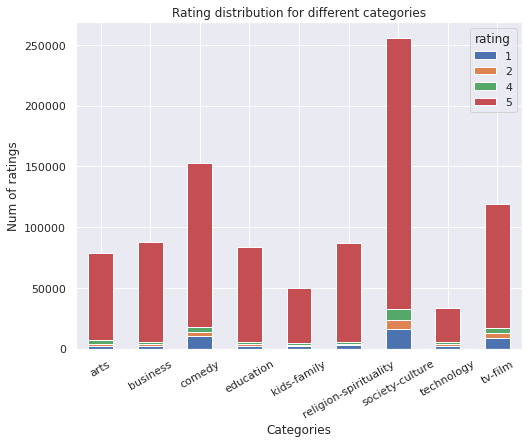

In [56]:
pd.crosstab(df.category, df.rating).plot(kind='bar', stacked=True)
sns.set_style("whitegrid")
plt.xticks(rotation=30, horizontalalignment="center")
plt.xlabel('Categories')
plt.title('Rating distribution for different categories')
plt.ylabel('Num of ratings')

Rating data is has a non-normal distribution, **majority of the ratings are 5 star** ratings.

### Reviews by year

In [18]:
df= df[df['creation_date'] != 0]

In [19]:
df.creation_date.value_counts()

2019    246731
2020    184280
2018    140244
2021     99670
2017     95351
2016     59009
2015     43072
2014     25310
2012     18209
2013     16350
2011     12642
2010      8447
2009      8162
2008      6110
2007      4413
2006      2654
2005       167
Name: creation_date, dtype: int64

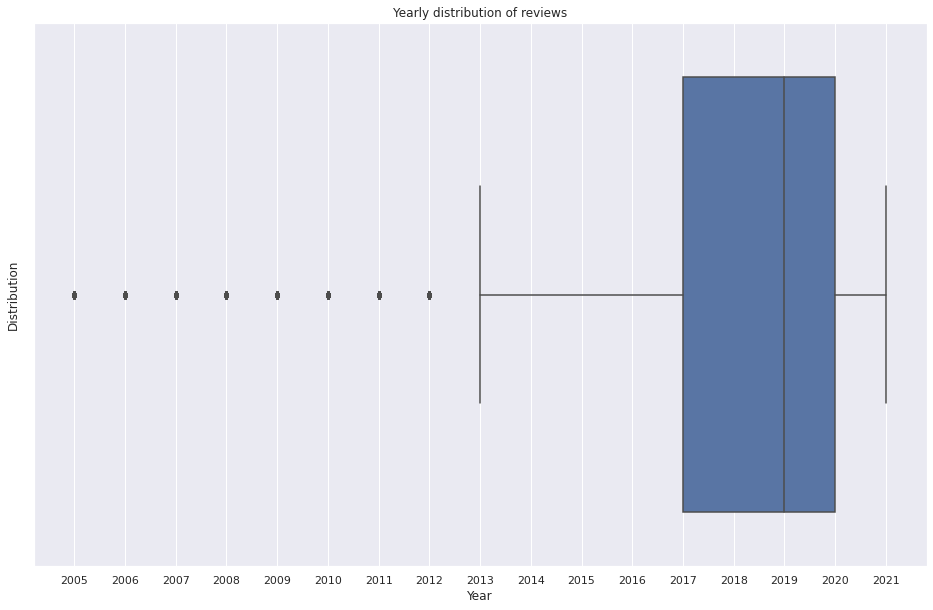

In [20]:
sns.set_style("whitegrid")
sns.set(rc={"figure.figsize":(16, 10)})
sns.boxplot(x="creation_date", data=df)
plt.xlabel('Year')
plt.ylabel('Distribution')
plt.xticks(df.creation_date.unique())
plt.title("Yearly distribution of reviews")
plt.show()

A large number of reviews were written in 2019. 50 % of all reviews were written between 2017 and 2020. 



## Classifying reviews to positive and negative 

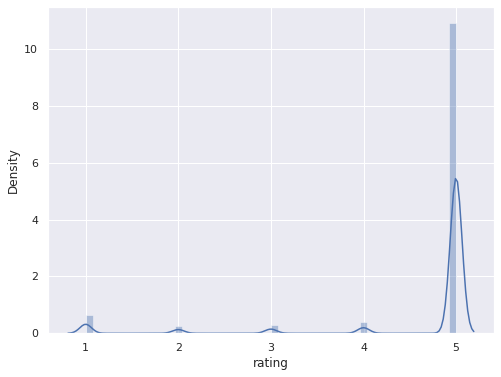

In [21]:
sns.set_style("whitegrid")
sns.set(rc={"figure.figsize":(8, 6)})
sns.distplot(df['rating']);

Most reviews come with a positive 5 star rating

TOP 3 podcast categories - **business, religion-spirituality and education**.

# Hypothesis testing

## Differences between category ratings 
H0 Mean (median) ratings are the same between any categories.

H1 Mean (median) ratings are different between any categories.

In [22]:
cat = df[['rating', 'category']]
cat[['category','rating']].groupby('category').agg(['count','mean', 'median', 'std'])

rating                           
                        count      mean median       std
category                                                
arts                    80096  4.752435    5.0  0.823359
business                89327  4.807415    5.0  0.760230
comedy                 156611  4.605232    5.0  1.091710
education               84588  4.800255    5.0  0.775900
kids-family             51216  4.716378    5.0  0.888624
religion-spirituality   87624  4.809447    5.0  0.769241
society-culture        263658  4.578435    5.0  1.094718
technology              34626  4.532201    5.0  1.133572
tv-film                123075  4.516067    5.0  1.172161

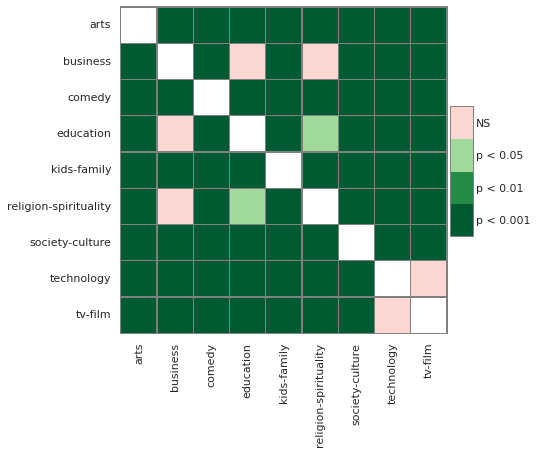

In [23]:
pc = sp.posthoc_conover(cat, val_col='rating', group_col='category', p_adjust = 'bonferroni')
heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
sp.sign_plot(pc, **heatmap_args);


## Religions and spirituality

Categories related to religion/spirituality:
- religion-spirituality
- spirituality
- christianity
- judaism
- buddhism
- islam
- hinduism

Some podcasts have a few categories, e.g. specific religions are also under the categories "religion-spirituality" and "spirituality". Therefore, I will compare only specific religions.

In [24]:
religions = pd.read_sql('''SELECT  r.rating, c.category 
                    FROM reviews r
                    JOIN categories c ON r.podcast_id = c.podcast_id
                    WHERE  c.category in ('christianity', 'judaism', 'buddhism', 'islam', 'hinduism');''', conn)
religions.head()

,rating,category
0,5,christianity
1,5,christianity
2,4,christianity
3,5,hinduism
4,5,hinduism


In [25]:
religions[['category','rating']].groupby('category').agg(['count','mean', 'median', 'std'])

rating                           
              count      mean median       std
category                                      
buddhism       1002  4.759481    5.0  0.798997
christianity  57903  4.799872    5.0  0.793167
hinduism        176  4.840909    5.0  0.690943
islam           832  4.783654    5.0  0.811365
judaism        1587  4.678009    5.0  1.015163

In [26]:
religions['rating'] = religions['rating'].apply(lambda x: float(x))

In [27]:
reli = [religions.loc[ids, 'rating'].values for ids in religions.groupby('category').groups.values()] # Create arrays of ratings for different religions'podcasts

In [28]:
H, p = stats.kruskal(*reli)
p

1.9709729752608675e-09

Kruskal Wallis shows us that there are significant diferences between groups.

The Krusal-Wallis H-test tests the null hypothesis that the population median of all of the groups are equal. It is a non-parametric version of ANOVA. A significant Kruskal–Wallis test indicates that at least one sample stochastically dominates one other sample. The test does not identify where this stochastic dominance occurs or for how many pairs of groups stochastic dominance obtains. Therefore, post-hoc comparisons between groups are required to determine which groups are different.

-----
To learn what groups  differ in their medians we need to run post hoc tests. Scikit-posthocs provides a lot of non-parametric tests. Let's choose Conover's test.

(<matplotlib.axes._subplots.AxesSubplot at 0x7f912dd64050>,
 <matplotlib.colorbar.ColorbarBase at 0x7f912de0cb90>)

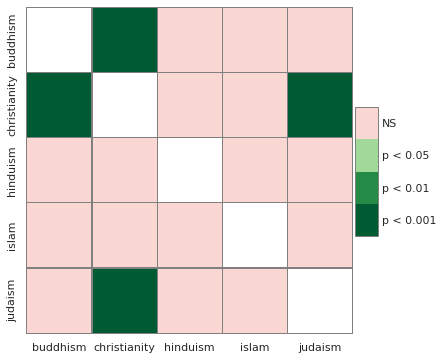

In [29]:
pc1 = sp.posthoc_conover(religions, val_col='rating', group_col='category', p_adjust = 'bonferroni')
heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
sp.sign_plot(pc1, **heatmap_args)

Pairwise post-hoc comparisons in which instances we can reject the null hypothesis - in cases where p < 0.01.

There are significant differences between **Christianity - Buddhism** and **Christianity - Judaism**. Christianity related podcasts are more positively rated in both cases.

In [30]:
# Further comparing christianity, buddhism and judaism categories on their rating
buddhism = religions.loc[religions['category'] == 'buddhism']
christianity = religions.loc[religions['category'] == 'christianity']
judaism = religions.loc[religions['category'] == 'judaism']

b = buddhism['rating'].values
c = christianity['rating'].values
j = judaism['rating'].values

In [31]:
# Z-test
print('Christianity podcasts vs. Buddhism podcasts:', ztest(c, b, value=0),  end='\n')
print('Christianity podcasts vs. Judaism podcasts:', ztest(c, j, value=0))

Christianity podcasts vs. Buddhism podcasts: (1.5979963327583648, 0.11004379324778756)
Christianity podcasts vs. Judaism podcasts: (5.987735879704762, 2.127822254182886e-09)


Z test confirms that there's a significant difference in ratings between **Christianity and Judaism** related podcasts, but not between other categories.

### Effect size and statistical power (for z test)
Since there's a significant difference between average ratings for **Christianity and Judaism**, we can look at the effect size (Cohen's d).

In [32]:
#Here the pooled standard deviation accounts for unequal sample sizes
def effect_size_cohensD(mean1,std1,count1,mean2,std2,count2):
    cohens_d = (mean1 - mean2) / np.sqrt(((count1 - 1) * std1 ** 2 + (count2 - 1) * std2 ** 2) / (count1 + count2 - 2))
    return cohens_d

if __name__ == '__main__':
    mean1 = christianity.mean(); std1 = christianity.std(); count1 = christianity.rating.count()
    mean2 = judaism.mean(); std2 = judaism.std(); count2 = judaism.rating.count()
    cohens_d = effect_size_cohensD(mean1, std1, count1, mean2, std2, count2)
    print(cohens_d)

rating    0.152351
dtype: float64


We have a very small effect size, less than 0.2

Statistical power is the probability that the test correctly rejects the Null Hypothesis if the Alternative Hypothesis is true.

In [33]:
effect_size = cohens_d
alpha = 0.05
ratio = count2/count1

In [34]:
from statsmodels.stats.power import zt_ind_solve_power as pwr

In [35]:
pwr(effect_size=effect_size, nobs1=count1, alpha=alpha, power=None, ratio=ratio, alternative='two-sided')

array([0.99997185])

Power has the values between 0 and 1. The larger the power (closer to 1), the less chance we have of making type II (false negative) error.

In this case, statistical power is large, perhaps due to a very large sample. Effect size is small, so the differences in groups is small, but reliably detectable, i.e. Christianity related podcasts are likely to be rated slightly higher than Judaism related podcasts, but other groups don't have a significant difference in ratings.

# Text analysis

## Sentiments

In [36]:
# Assign reviews with score > 3 as positive sentiment rating; < 3 as negative sentiment rating; remove rating = 3
df = df[df['rating'] != 3]
df['sentiment'] = df['rating'].apply(lambda rating : +1 if rating > 3 else 0)

In [37]:
df.head()

,title,author_id,review_title,review,rating,creation_date,category,cleaned,sentiment
2,Backstage at Tilles Center,F7E5A318989779D,really interesting!,Thanks for providing these insights. Really e...,5,2018,arts,thanks for providing these insights really enj...,1
5,Backstage at Tilles Center,F6BF5472689BD12,Must listen for anyone interested in the arts!!!,Super excited to see this podcast grow. So man...,5,2018,arts,super excited to see this podcast grow so many...,1
8,TED Talks Daily,1AB95B8E6E1309E,nauseatingly left,"I'm a liberal myself, but its pretty obvious a...",1,2019,education,i m a liberal myself but its pretty obvious an...,0
11,TED Talks Daily,11BB760AA5DEBD1,Diverse stories,I find Tedx talks very inspirational but I oft...,5,2018,education,i find tedx talks very inspirational but i oft...,1
14,TED Talks Daily,D86032C8E57D15A,👍👍👍👍,"I love this podcast, it is so good.",5,2019,education,i love this podcast it is so good,1


In [38]:
# Split df to positive and negative sentiment:
positive = df[df['sentiment'] == 1]
negative = df[df['sentiment'] == 0]

## WordCloud

In [39]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [40]:
stop_words = set(stopwords.words('english'))

new_stopwords = ["podcast", "podcasts", "show", "shows", "episode", "episodes", "one", "listen", "listening", "listened", "listener", "look(\s?\\.?\s?)forward", "look", "looking", "also", "though", "found",
                 "people", "really", "love", "like", "good", "much", "many", "used", "said" "enough", "got", "don", "thank", "go", "still", "now", "need", "feel", "know", "talk", "us", "seem", "re", "lot", "make", "even", "sure", "sometime", "sometimes",
                 "often", "time", "listening(\s?\\.?\s?)podcast", "feel(\s?\\.?\s?)like", "every", "podcast(\s?\\.?\s?)love", "especially", "get", "seems", "say", "take", "would", "want", "alway", "think", 
                 "storie", "actually", "way", "thing"]

In [41]:
stop_words = stop_words.union(new_stopwords)

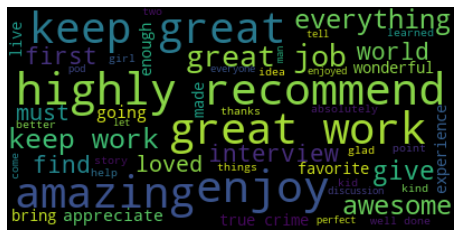

In [42]:
pos = " ".join(review for review in positive.cleaned)
wordcloud2 = WordCloud(stopwords=stop_words, max_words=50).generate(pos)
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.show()

Unsurprisingly, positive reviews among all categories, contained a lot of appreciative words and phrases, such as "highly recommend", "great job", "great work". Adjectives, such as "amazing", "awesome", "wonderful".

Some nouns, such as "true crime", "family", "girl", "man", "kid" and also words that might indicate what aspects listeners were enjoying in the podcasts -
"interview", "discussion".

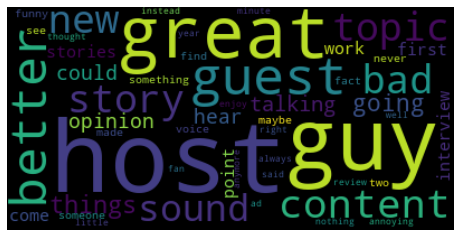

In [43]:
neg = " ".join(review for review in negative.cleaned)
wordcloud3 = WordCloud(stopwords=stop_words,max_words=50).generate(neg)
plt.imshow(wordcloud3, interpolation='bilinear')
plt.axis("off")
plt.savefig('wordcloud33.png')
plt.show()

Generally, many negative reviews featured the words "host", "guy", "content", "sound", "opinion", "topic", "story", which may indicate what aspects were disliked by listeners.

Further, let's look at TOP 3 highest rated podcast categories, and what key-words dominate in positive and negative reviews. Top rated categories on average are - **business, education, religion-siprituality**.           

## Top 3 highest rated categories

### Business podcasts

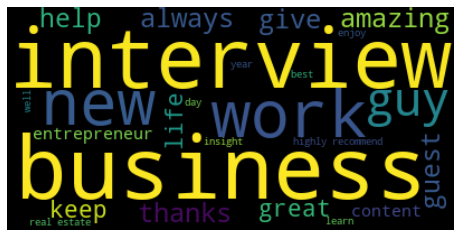

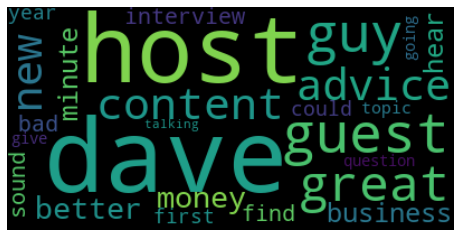

In [44]:
pos_business = positive[positive.category.isin(['business'])] # Positive

pos_b = " ".join(review for review in pos_business.cleaned)
wordcloud3 = WordCloud(stopwords=stop_words, max_words=25).generate(pos_b)
plt.imshow(wordcloud3, interpolation='bilinear')
plt.axis("off")
plt.show()

neg_business = negative[negative.category.isin(['business'])] # Negative


neg_b = " ".join(review for review in neg_business.cleaned)
wordcloud4 = WordCloud(stopwords=stop_words, max_words=25).generate(neg_b)
plt.imshow(wordcloud4, interpolation='bilinear')
plt.axis("off")
plt.show()

Some frequently appearing words in **positive** reviews include, unsurprisingly "business", also "work", "interview", "entrepreneur",

**Negative** reviews included "host", "dave", "guy", "guest", "content, "advice".

"Guy" was often mentioned in both types of reviews.

### Education podcasts

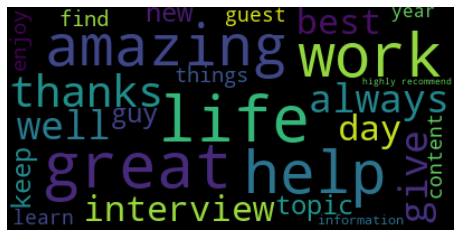

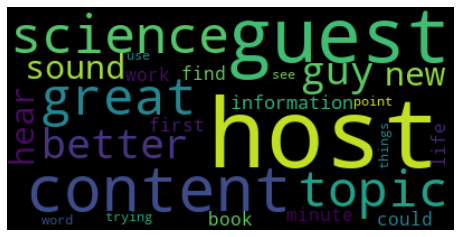

In [45]:
# Education

pos_education = positive[positive.category.isin(['education'])]

pos_ed = " ".join(review for review in pos_education.cleaned)
wordcloud3 = WordCloud(stopwords=stop_words, max_words=25).generate(pos_ed)
plt.imshow(wordcloud3, interpolation='bilinear')
plt.axis("off")
plt.show()

neg_education = negative[negative.category.isin(['education'])]

neg_ed = " ".join(review for review in neg_education.cleaned)
wordcloud4 = WordCloud(stopwords=stop_words, max_words=25).generate(neg_ed)
plt.imshow(wordcloud4, interpolation='bilinear')
plt.axis("off")
plt.show()

For education related podcasts that were rated **positively**, some frequent key-words are 'life', 'true crime', 'world', so listeners probably enjoy podcasts on these topics. Other popular words are 'interview', 'host', so people are probably complimenting these aspects.

However 'host' also is the top word in the **negative** reviews corpus, along with 'guy'. That likely means, that people often critize podcasts hosts and their negative feedback is about them. Other frequent words are "guest", "topic", "content", more specific nous mentioned - "science", "information", "book".

### Religion-siprituality podcasts

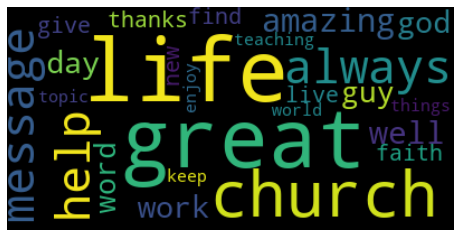

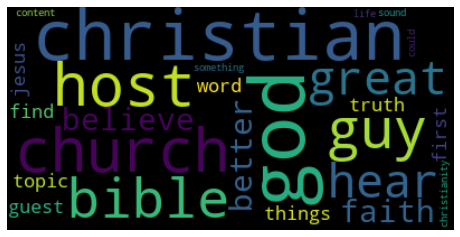

In [46]:
pos_religion = positive[positive.category.isin(['religion-spirituality'])]

pos_reli = " ".join(review for review in pos_religion.cleaned)
wordcloud3 = WordCloud(stopwords=stop_words, max_words=25).generate(pos_reli)
plt.imshow(wordcloud3, interpolation='bilinear')
plt.axis("off")
plt.show()

neg_religion = negative[negative.category.isin(['religion-spirituality'])]

neg_reli = " ".join(review for review in neg_religion.cleaned)
wordcloud4 = WordCloud(stopwords=stop_words, max_words=25).generate(neg_reli)
plt.imshow(wordcloud4, interpolation='bilinear')
plt.axis("off")
plt.show()

Some frequently appearing words in positive reviews include nous, such as "life", "church", "faith", also words like "message", "help", "teaching" - which may indicate what listeners enjoy in religious and spiritual podcasts.

Negative reviews included nouns like "god", "church", "christian", "bible". Also "host", "guy".

"Church" was often mentioned in both types of reviews, it's probably generally a popular discussion topic in these types of podcasts.

## Word matrices

In [47]:
from sklearn.feature_extraction.text import CountVectorizer

In [48]:
# Converting the 'cleaned' column to lists
positive_list = positive['cleaned'].astype(str).tolist() 
negative_list = negative['cleaned'].astype(str).tolist()

## Positive and negative associations: bi-grams

In [49]:
vectorizer1 = CountVectorizer(stop_words=stop_words, ngram_range=(2, 2), max_features=20)
vectorizer2 = CountVectorizer(stop_words=stop_words, ngram_range=(2, 2), max_features=20)

In [50]:
matrix_pos = vectorizer1.fit_transform(positive_list)
matrix_neg = vectorizer2.fit_transform(negative_list)

# Create document term matrix
df_dtm_pos = pd.DataFrame(matrix_pos.toarray(), index=positive['rating'].values, columns=vectorizer1.get_feature_names())
df_dtm_neg = pd.DataFrame(matrix_neg.toarray(), index=negative['rating'].values, columns=vectorizer2.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['forward'] not in stop_words.
  % sorted(inconsistent)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['forward'] not in stop_words.
  % sorted(inconsistent)


In [51]:
df_dtm_pos['rating'] = positive['rating'].values
df_dtm_pos.set_index('rating')

,best ever,forward new,forward week,great content,great guests,great job,great work,highly recommend,keep coming,keep great,keep work,learn something,pop culture,real estate,real life,something new,thought provoking,true crime,wait hear,well done
rating,,,,,,,,,,,,,,,,,,,,
5,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [52]:
corr_pos = df_dtm_pos[df_dtm_pos.columns[1:]].corr()['rating'][:].sort_values(ascending=False)
corr_pos = corr_pos.drop(labels='rating')

Text(0.5, 1.0, 'Top 20 most common positive review bi-grams and their correlation with positive ratings')

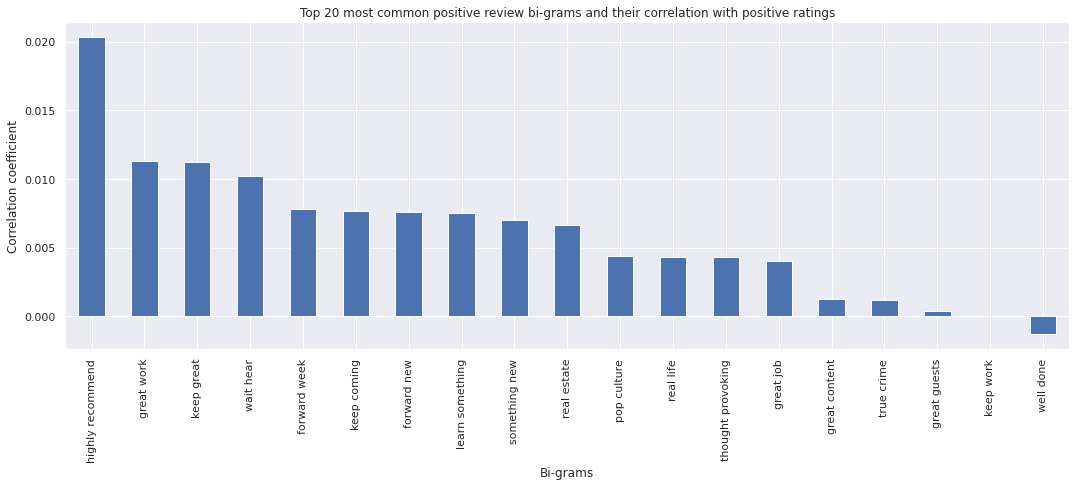

In [53]:
corr_pos.plot(kind='bar', figsize=(18,6))
plt.xlabel('Bi-grams')
plt.ylabel('Correlation coefficient')
plt.title("Top 20 most common positive review bi-grams and their correlation with positive ratings")

Some semantically meaningful bi-grams that may reflect popular podcast topics are "real estate", "pop culture", "real life", "true crime". The matrix also includes positive comments about aspects of podcasts. Correlation coefficients for separe bi-grams are pretty low.

In [54]:
df_dtm_neg['rating'] = negative['rating'].values
df_dtm_neg.set_index('rating')

,audio quality,bring back,bts bts,co host,come back,ever heard,fast forward,first minutes,high school,please stop,political views,social media,someone else,sound quality,star wars,subject matter,tell story,true crime,year old,years ago
rating,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Text(0.5, 1.0, 'Top 20 most common negative review bi-grams and their correlation with negative ratings')

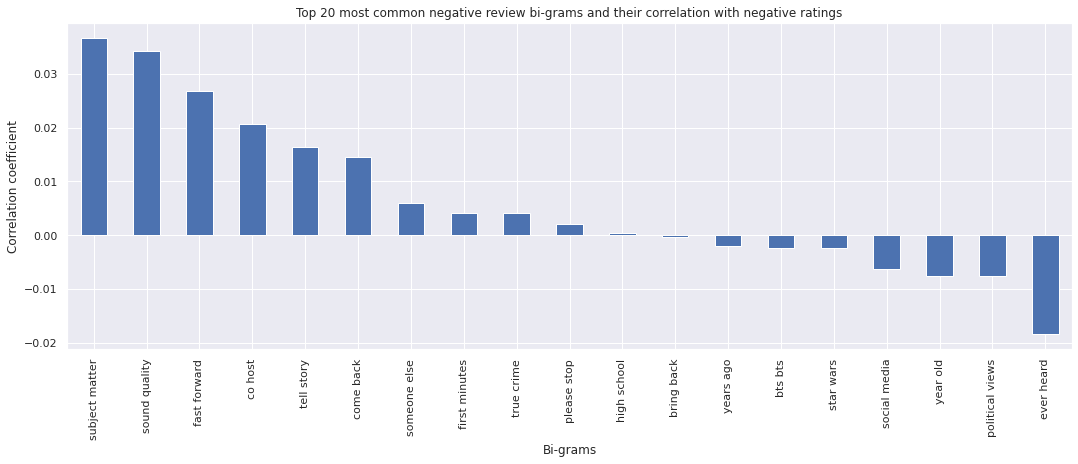

In [55]:
corr_neg = df_dtm_neg[df_dtm_neg.columns[1:]].corr()['rating'][:].sort_values(ascending=False)
corr_neg = corr_neg.drop(labels='rating')

corr_neg.plot(kind='bar', figsize=(18,6))
plt.xlabel('Bi-grams')
plt.ylabel('Correlation coefficient')
plt.title("Top 20 most common negative review bi-grams and their correlation with negative ratings")

Some interesting bi-grams in the negative reviews include "subject matter", "sound quality", "co host", "first minutes" - which might be indicative what people disliked generally. Some more concrete topics, such as "high school", "true crime", which was also mentioned in positive reviews. Also words that correlated negatively, even though correlation was weak - "bts bts", "star wars", "social media", "political views".

# **Conclusions**

**Hypothesis testing**

1. **All categories.** There are significant differences in average ratings between most categories, except top 3 rated (business and education, business and religion-spirituality) and 2 lowest rated (tv-film and technology).


2. **Religion related podcasts.** Christianity related podcasts are likely to be rated slightly higher than Judaism related podcasts, but other groups don't have a significant difference in ratings. The highest rated podcasts are about hinduism, but there's also the least of them. Christianity has the highest amount of podcasts and reviews.

**Text analysis**
1. **Word clouds**
* Generally, positive reviews include positive adjectives, nouns, such as "true crime", "family", "girl", "man", "kid" and also words that might indicate what aspects listeners were enjoying in the podcasts - "interview", "discussion".
* Negative reviews often include words "host" and "guy", which is probably one the most common reasons why people gave podcasts negative reviews.

2. **Bi-grams**
* Some semantically meaningful bi-grams that may reflect popular podcast topics are "real estate", "pop culture", "real life", "true crime" for positive reviews and "bts bts", "star wars", "social media", "political views" among negative reviews (negative correlation with negative ratings). The fact that there's a negative correlation likely means that these words aren't exclusively related to negative sentiment. They were most likely common topics in positive reviews, but not popular enough to make it to top 20 in positive reviews.
* Some interesting bi-grams in the negative reviews include "subject matter", "sound quality", "co host", "first minutes" - which might be indicative what people disliked generally. Some more concrete topics, such as "high school", "true crime", which was also mentioned in positive reviews.

In general, there was a larger corpus of positive reviews, compared to negative reviews, which indicates that people are more likely to give positive feedback. It also means that the median ratings for all podcast categories was 5.

